In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

# Read in the data

In [60]:
df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')
df.head()

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,21.0,Female,1.62,64.0,no,no,2.0,3.0,no,no,2.0,yes,0.0,1.0,Sometimes,Public_Transportation,Normal_Weight
1,21.0,Female,1.52,56.0,Sometimes,no,3.0,3.0,yes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,23.0,Male,1.80,77.0,Frequently,no,2.0,3.0,no,no,2.0,yes,2.0,1.0,Sometimes,Public_Transportation,Normal_Weight
3,27.0,Male,1.80,87.0,Frequently,no,3.0,3.0,no,no,2.0,no,2.0,0.0,Sometimes,Walking,Overweight_Level_I
4,22.0,Male,1.78,89.8,Sometimes,no,2.0,1.0,no,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


# Basic info about the data

In [61]:
print(df.info(), '\n')
print('Количество пропусков = ', df.isnull().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             2111 non-null   float64
 1   Gender                          2111 non-null   object 
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   CALC                            2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   SCC                             2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  family_history_with_overweight  2111 non-null   object 
 12  FAF                             21

In [62]:
df['FAVC'] = df['FAVC'].map({'no': 0, 'yes': 1})
df['SCC'] = df['SCC'].map({'no': 0, 'yes': 1})
df['SMOKE'] = df['SMOKE'].map({'no': 0, 'yes': 1})
df['family_history_with_overweight'] = df['family_history_with_overweight'].map({'no': 0, 'yes': 1})
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
df['CALC'] = df['CALC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
df['CAEC'] = df['CAEC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
df['MTRANS'] = df['MTRANS'].map({'Automobile': 0, 'Bike': 1, 'Motorbike': 2, 'Public_Transportation': 3, 'Walking': 4})
df['NObeyesdad'] = df['NObeyesdad'].map({
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
})

In [63]:
print(df.info(), '\n')
print('Количество пропусков = ', df.isnull().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             2111 non-null   float64
 1   Gender                          2111 non-null   int64  
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   CALC                            2111 non-null   int64  
 5   FAVC                            2111 non-null   int64  
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   SCC                             2111 non-null   int64  
 9   SMOKE                           2111 non-null   int64  
 10  CH2O                            2111 non-null   float64
 11  family_history_with_overweight  2111 non-null   int64  
 12  FAF                             21

In [64]:
df.describe()

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,0.505921,1.701677,86.586058,0.731407,0.883941,2.419043,2.685628,0.045476,0.020843,2.008011,0.817622,1.010298,0.657866,1.140692,2.365230,3.112269
std,6.345968,0.500083,0.093305,26.191172,0.515498,0.320371,0.533927,0.778039,0.208395,0.142893,0.612953,0.386247,0.850592,0.608927,0.468543,1.261423,1.985062
min,14.000000,0.000000,1.450000,39.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.947192,0.000000,1.630000,65.473343,0.000000,1.000000,2.000000,2.658738,0.000000,0.000000,1.584812,1.000000,0.124505,0.000000,1.000000,3.000000,1.000000
50%,22.777890,1.000000,1.700499,83.000000,1.000000,1.000000,2.385502,3.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.625350,1.000000,3.000000,3.000000
75%,26.000000,1.000000,1.768464,107.430682,1.000000,1.000000,3.000000,3.000000,0.000000,0.000000,2.477420,1.000000,1.666678,1.000000,1.000000,3.000000,5.000000
max,61.000000,1.000000,1.980000,173.000000,3.000000,1.000000,3.000000,4.000000,1.000000,1.000000,3.000000,1.000000,3.000000,2.000000,3.000000,4.000000,6.000000


In [66]:
df.columns

Index(['Age', 'Gender', 'Height', 'Weight', 'CALC', 'FAVC', 'FCVC', 'NCP',
       'SCC', 'SMOKE', 'CH2O', 'family_history_with_overweight', 'FAF', 'TUE',
       'CAEC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [69]:
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['Age', 'Gender', 'Height', 'Weight', 'CALC', 'FAVC', 'FCVC', 'NCP',
       'SCC', 'SMOKE', 'CH2O', 'family_history_with_overweight', 'FAF', 'TUE',
       'CAEC', 'MTRANS']

# Создаем экземпляр MinMaxScaler
scaler = MinMaxScaler()

# Нормализуем только выбранные столбцы
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Выводим результат
df.head()

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,0.148936,0.0,0.320755,0.186567,0.000000,0.0,0.5,0.666667,0.0,0.0,0.5,1.0,0.000000,0.5,0.333333,0.75,1
1,0.148936,0.0,0.132075,0.126866,0.333333,0.0,1.0,0.666667,1.0,1.0,1.0,1.0,1.000000,0.0,0.333333,0.75,1
2,0.191489,1.0,0.660377,0.283582,0.666667,0.0,0.5,0.666667,0.0,0.0,0.5,1.0,0.666667,0.5,0.333333,0.75,1
3,0.276596,1.0,0.660377,0.358209,0.666667,0.0,1.0,0.666667,0.0,0.0,0.5,0.0,0.666667,0.0,0.333333,1.00,2
4,0.170213,1.0,0.622642,0.379104,0.333333,0.0,0.5,0.000000,0.0,0.0,0.5,0.0,0.000000,0.0,0.333333,0.75,3


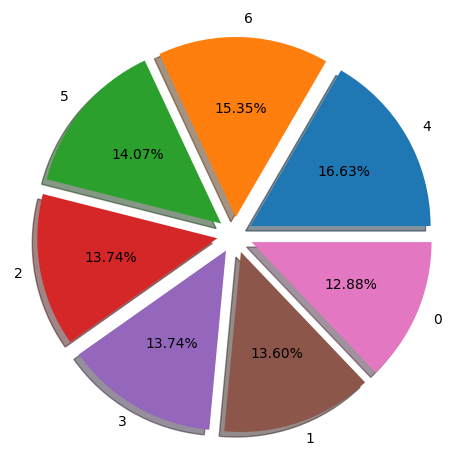

In [73]:
ax =plt.subplot(1,1,1)
ax=df['NObeyesdad'].value_counts().plot.pie(explode=[0.1, 0.1,0.1,0.1, 0.1,0.1, 0.1],autopct='%1.2f%%',shadow=True);
plt.tight_layout()
plt.axis('off');

# Correlation matrix

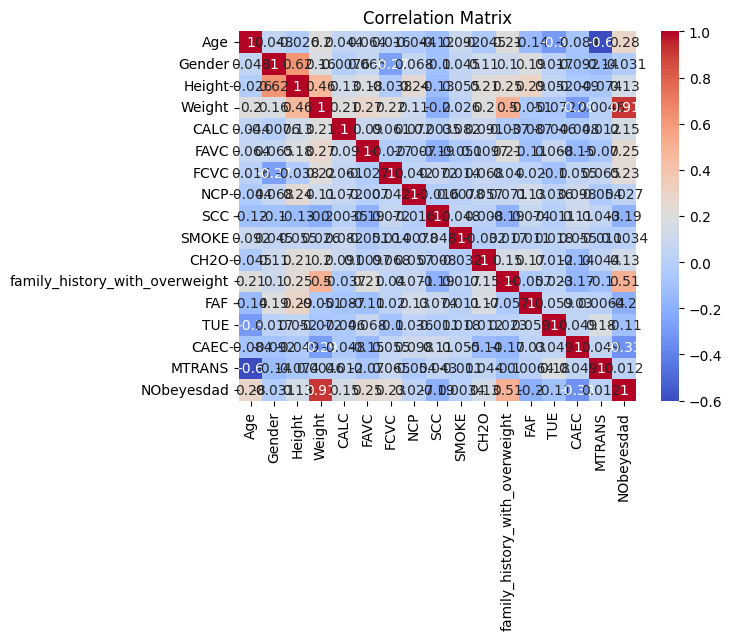

In [74]:
import seaborn as sns

numerical_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_df.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

No conclusive evidence can be drawn from this correlation matrix other than height and weight show a considerable amount of correlation

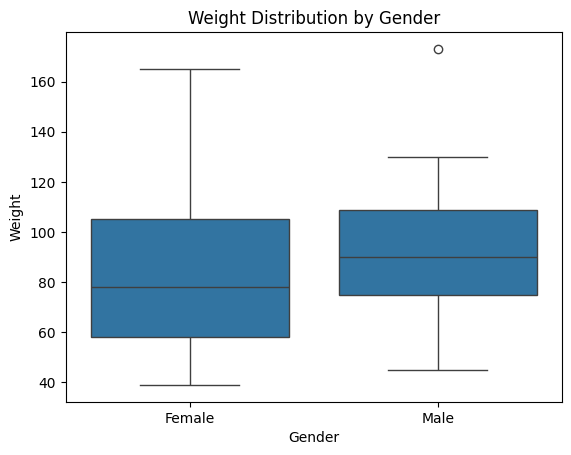

In [12]:

sns.boxplot(x='Gender', y='Weight', data=df)
plt.title('Weight Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Weight')
plt.show()

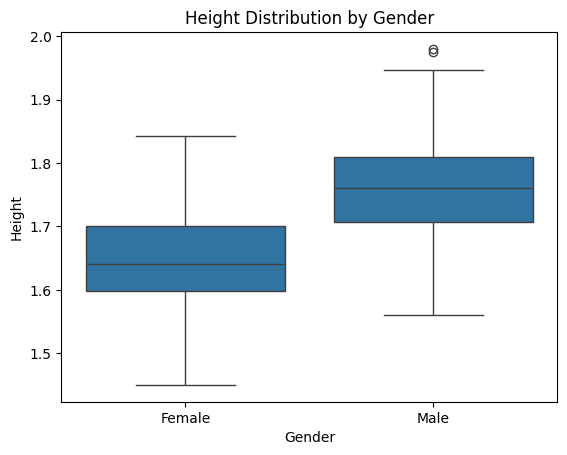

In [13]:
sns.boxplot(x='Gender', y='Height', data=df)
plt.title('Height Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Height')
plt.show()

We can see that males tend to weight more which is not suprising because males are usually taller than females and previously we discovered the correlation between height and weight

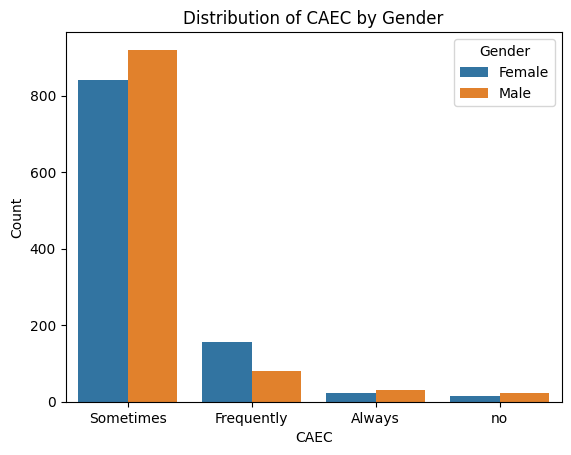

In [14]:


sns.countplot(x='CAEC', hue='Gender', data=df)
plt.title('Distribution of CAEC by Gender')
plt.xlabel('CAEC')
plt.ylabel('Count')
plt.show()

This graph shows that males tend to snack more between meals

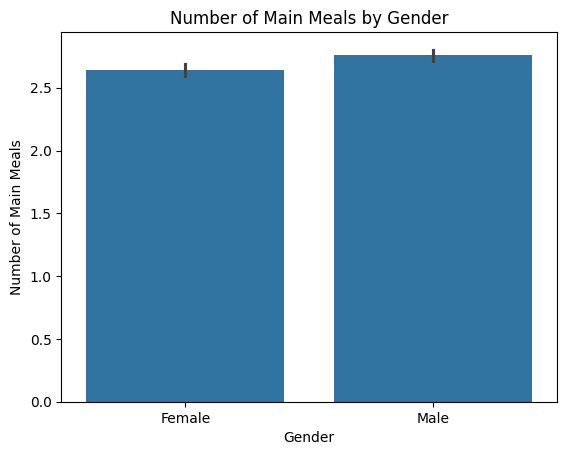

In [15]:
sns.barplot(x='Gender', y='NCP', data=df)
plt.title('Number of Main Meals by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Main Meals')
plt.show()

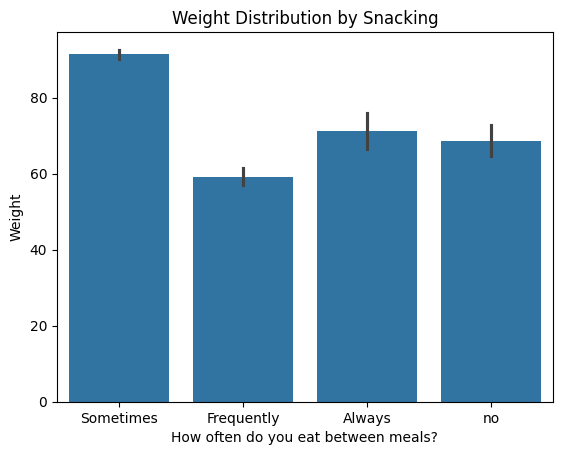

In [16]:
import seaborn as sns

import matplotlib.pyplot as plt

sns.barplot(x='CAEC', y='Weight', data=df)
plt.title('Weight Distribution by Snacking')
plt.xlabel('How often do you eat between meals?')
plt.ylabel('Weight')
plt.show()

This graph is pretty weird because it shows how people who say Sometimes probably underestimate how often they snack and the people who say frequently are probably overestimating their snacking habbits

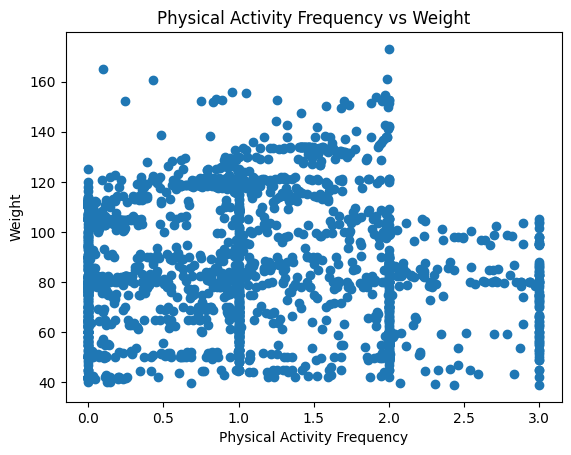

In [17]:
import matplotlib.pyplot as plt

plt.scatter(df['FAF'], df['Weight'])
plt.title('Physical Activity Frequency vs Weight')
plt.xlabel('Physical Activity Frequency')
plt.ylabel('Weight')
plt.show()

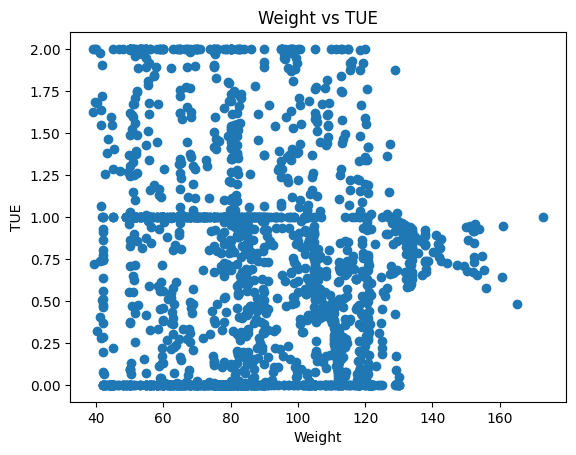

In [18]:
import matplotlib.pyplot as plt

plt.scatter(df['Weight'], df['TUE'])
plt.title('Weight vs TUE')
plt.xlabel('Weight')
plt.ylabel('TUE')
plt.show()

We can see that the average technology user weighs the most on average which is interesting

# LabelEncoder and splitting

In [94]:
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split


X = df.drop(columns=['NObeyesdad'])
y = df['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
# Используем StratifiedKFold для обеспечения стратифицированной кросс-валидации
# Это объект кросс-валидации, который позволяет сохранить процент образцов для каждого класса в каждом фоне.
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)  
# 5 образцов для кросс-валидации

# Создаем объект для уменьшения выборки для большинства
sampler = RandomUnderSampler()

# Fitting the models

In [82]:
tuned_classifiers = {
   "Logistic Regression": LogisticRegression(max_iter=10000, random_state=42),
   "KNearest": KNeighborsClassifier(n_neighbors=6),
   "Gaussian Naive Bayes": GaussianNB(),
   "Decision Tree Classifier": DecisionTreeClassifier(random_state=42),
   "Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=100, learning_rate=0.4, max_depth=5, random_state=42),
   "Support Vector Classifier": SVC(kernel='rbf', gamma='auto', C=1.0),
   "Random Forest Classifier": RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42),
}

In [88]:
import time

accuracy_data = []

for key, classifier in tuned_classifiers.items():
   time1 = time.time()
    # Создаем список шагов для пайплайна машинного обучения
   steps = [ ('u', sampler), ('model', classifier)]  # Шаги: увеличенная выборка, уменьшенная выборка и модель

    # Создаем пайплайн машинного обучения
   FiPipeline = Pipeline(steps=steps) 

    # Кросс-валидация классификаторов с использованием определенного пайплайна
   scores = cross_val_score(FiPipeline, X_train, y_train, cv=skf)  

   time2 = time.time()

   accuracy = round(scores.mean() * 100, 2)
   accuracy_data.append([key, accuracy])

   print(f"Название: {key}, оценка точности: {accuracy} %, время обучения : {(time2-time1):0.2f} секунд")

Название: Logistic Regression, оценка точности: 69.67 %, время обучения : 0.42 секунд
Название: KNearest, оценка точности: 74.88 %, время обучения : 0.27 секунд
Название: Gaussian Naive Bayes, оценка точности: 57.7 %, время обучения : 0.07 секунд
Название: Decision Tree Classifier, оценка точности: 91.77 %, время обучения : 0.09 секунд
Название: Gradient Boosting Classifier, оценка точности: 96.68 %, время обучения : 14.42 секунд
Название: Support Vector Classifier, оценка точности: 59.42 %, время обучения : 0.52 секунд
Название: Random Forest Classifier, оценка точности: 94.61 %, время обучения : 1.60 секунд


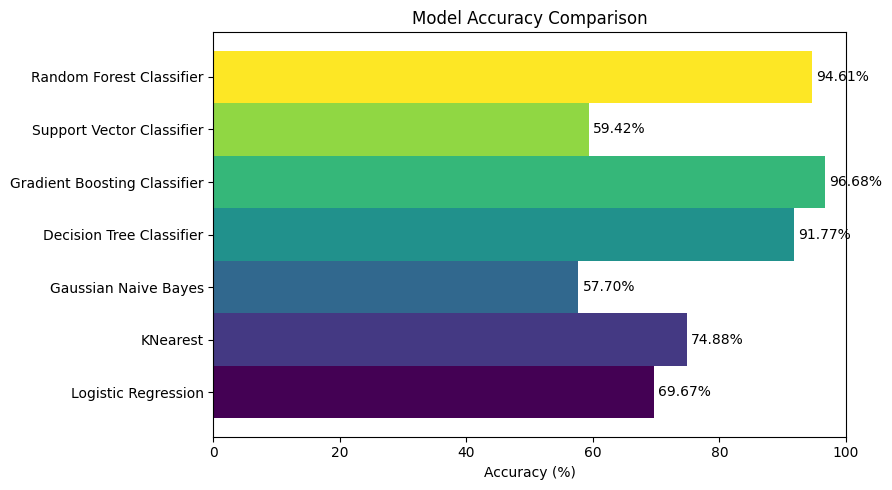

In [89]:
import matplotlib.pyplot as plt

# Получаем название + точность
models = [item[0] for item in accuracy_data]
accuracies = [item[1] for item in accuracy_data]

colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

plt.figure(figsize=(9, 5))
bar_width = 1
bars = plt.barh(models, accuracies, height=bar_width, color=colors)

plt.xlabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.yticks(models)
plt.xlim(0, 100)

def autolabel(bars):
    for bar in bars:
        width = bar.get_width()
        plt.annotate(f'{width:.2f}%',
                     xy=(width, bar.get_y() + bar.get_height() / 2),
                     xytext=(3, 0),
                     textcoords="offset points",
                     ha='left', va='center')

autolabel(bars)

plt.tight_layout()
plt.show()

                         precision    recall  f1-score   support

Insufficient_Weight (0)       0.95      0.96      0.96        56
      Normal_Weight (1)       0.92      0.89      0.90        62
 Overweight_Level_I (2)       0.88      0.93      0.90        56
Overweight_Level_II (3)       0.98      0.98      0.98        50
     Obesity_Type_I (4)       0.99      0.95      0.97        78
    Obesity_Type_II (5)       0.97      0.98      0.97        58
   Obesity_Type_III (6)       1.00      1.00      1.00        63

               accuracy                           0.96       423
              macro avg       0.95      0.96      0.95       423
           weighted avg       0.96      0.96      0.96       423



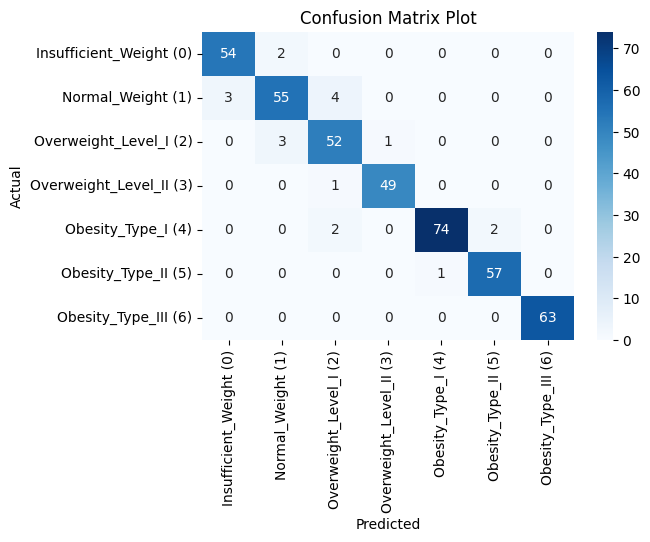

In [92]:
model = Pipeline([
        ('u', RandomUnderSampler()),
        ("Gradient Boosting", GradientBoostingClassifier(n_estimators=100, learning_rate=0.4, max_depth=5, random_state=42)) ])

model.fit(X_train, y_train)
prediction = model.predict(X_test)

# Вывод метрик
labels = ['Insufficient_Weight (0)', 'Normal_Weight (1)', 'Overweight_Level_I (2)', 'Overweight_Level_II (3)', 'Obesity_Type_I (4)', 'Obesity_Type_II (5)', 'Obesity_Type_III (6)']
print(classification_report(y_test, prediction, target_names=labels))

conf_matrix = confusion_matrix(y_test, prediction)
cm_df = pd.DataFrame(conf_matrix, index=['Insufficient_Weight (0)', 'Normal_Weight (1)', 'Overweight_Level_I (2)', 'Overweight_Level_II (3)', 'Obesity_Type_I (4)', 'Obesity_Type_II (5)', 'Obesity_Type_III (6)'], columns=['Insufficient_Weight (0)', 'Normal_Weight (1)', 'Overweight_Level_I (2)', 'Overweight_Level_II (3)', 'Obesity_Type_I (4)', 'Obesity_Type_II (5)', 'Obesity_Type_III (6)'])

pd.options.display.float_format = '{:.0f}'.format

plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='g', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Plot")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV from xgboost import XGBClassifier
param_grid = { 'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.01, 0.2], 'gamma': [0, 0.1, 0.3], 'subsample': [0.7, 0.8, 0.9], 'min_child_weight': [1, 3, 5], }
xgb = XGBClassifier()
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3)
best_params = grid_search.best_params_ best_score = grid_search.best_score_
print("Best Parameters:", best_params) print("Best Score:", best_score)